<a href="https://colab.research.google.com/github/MuhammadShavaiz/AI_learning/blob/main/Sentiment_Analysis_for_Binary_and_Multiclass_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis for Binary and Multiclass Problems
### IMDB and Aiplane Review Dataset

## Importing Requirements

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import pickle
from sklearn.metrics import precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from time import time

## Preprocessing and Feature Extraction

In [1]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load IMDb dataset
# Replace with your dataset path from Google Drive or use Kaggle API
df = pd.read_csv('IMDB Dataset.csv')
reviews = df['review'].values[:1000]  # Using first 1000 reviews for demonstration

# Text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and short words
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    return ' '.join(tokens), tokens

# Clean all reviews
print("Cleaning texts...")
cleaned_texts = []
tokenized_texts = []
for review in reviews:
    cleaned, tokens = clean_text(review)
    cleaned_texts.append(cleaned)
    tokenized_texts.append(tokens)

# 1. Bag of Words (BoW)
print("\nGenerating BoW features...")
bow_vectorizer = CountVectorizer(max_features=5000)
bow_matrix = bow_vectorizer.fit_transform(cleaned_texts)

# Get feature names for BoW
bow_features = bow_vectorizer.get_feature_names_out()

# 2. TF-IDF
print("Generating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_texts)

# Get feature names for TF-IDF
tfidf_features = tfidf_vectorizer.get_feature_names_out()

# 3. Word2Vec
print("Training Word2Vec model...")
w2v_model = Word2Vec(sentences=tokenized_texts,
                    vector_size=100,
                    window=5,
                    min_count=1,
                    workers=4)

# Function to create document vectors from Word2Vec
def get_document_vector(tokens, model):
    doc_vector = np.zeros(model.vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            doc_vector += model.wv[word]
            count += 1
    if count != 0:
        doc_vector /= count
    return doc_vector

# Generate document vectors using Word2Vec
doc_vectors = np.array([get_document_vector(tokens, w2v_model)
                       for tokens in tokenized_texts])

# Display results for a sample review
print("\nSample Results for First Review:")
print("Original text:", reviews[0][:100], "...")
print("\nCleaned text:", cleaned_texts[0][:100], "...")

print("\nFeature Matrix Shapes:")
print(f"BoW Matrix Shape: {bow_matrix.shape}")
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Word2Vec Document Vectors Shape: {doc_vectors.shape}")

# Display top features for first document
print("\nTop 10 BoW features for first document:")
nonzero_bow_indices = bow_matrix[0].nonzero()[1]
bow_scores = zip(bow_features[nonzero_bow_indices],
                bow_matrix[0].toarray()[0][nonzero_bow_indices])
print(sorted(bow_scores, key=lambda x: x[1], reverse=True)[:10])

print("\nTop 10 TF-IDF features for first document:")
nonzero_tfidf_indices = tfidf_matrix[0].nonzero()[1]
tfidf_scores = zip(tfidf_features[nonzero_tfidf_indices],
                  tfidf_matrix[0].toarray()[0][nonzero_tfidf_indices])
print(sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Cleaning texts...

Generating BoW features...
Generating TF-IDF features...
Training Word2Vec model...

Sample Results for First Review:
Original text: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The ...

Cleaned text: one reviewers mentioned watching episode youll hooked right exactly happened methe first thing struc ...

Feature Matrix Shapes:
BoW Matrix Shape: (1000, 5000)
TF-IDF Matrix Shape: (1000, 5000)
Word2Vec Document Vectors Shape: (1000, 100)

Top 10 BoW features for first document:
[('violence', 4), ('show', 3), ('prison', 3), ('forget', 3), ('watching', 2), ('episode', 2), ('right', 2), ('first', 2), ('struck', 2), ('city', 2)]

Top 10 TF-IDF features for first document:
[('violence', 0.2841233063770951), ('prison', 0.2701623846966722), ('forget', 0.24158898125854802), ('struck', 0.19415012571125373), ('show', 0.16526331610379644), ('due', 0.1488405836139065), ('episode', 0.14445098055854408), ('city', 0.1428399221373832

## Binary Sentiment Classification


Model Performance Comparison:
         model_name feature_type  accuracy  precision  recall  f1_score  train_time  predict_time
Logistic Regression          BoW    0.8767     0.8768  0.8766    0.8767     12.3054        0.0199
Logistic Regression       TF-IDF    0.8923     0.8890  0.8966    0.8928      0.9436        0.0044
        Naive Bayes          BoW    0.8375     0.8466  0.8244    0.8353      0.0537        0.0133
        Naive Bayes       TF-IDF    0.8553     0.8521  0.8598    0.8559      0.0557        0.0111


<ipython-input-11-c26e495b0ec8>:59: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


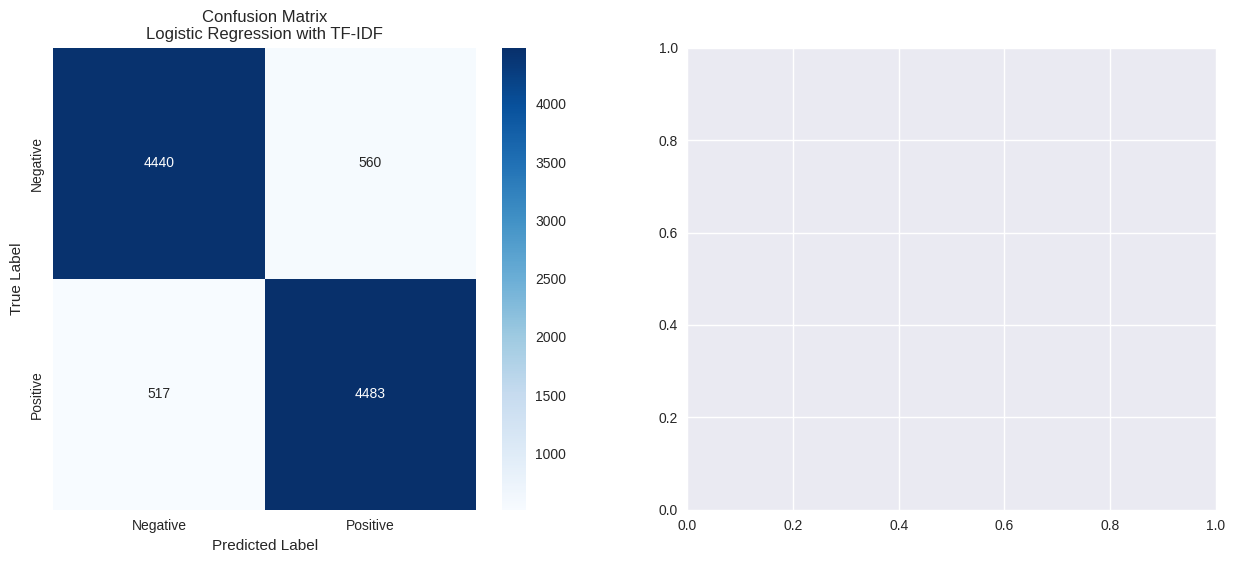

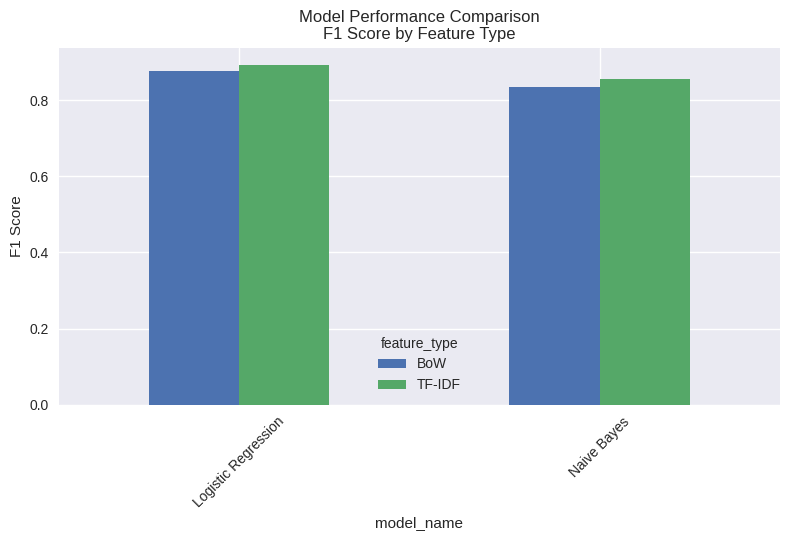


Best Model Performance Summary:
Model: Logistic Regression
Feature Type: TF-IDF

Metrics:
Accuracy: 0.8923
Precision: 0.8890
Recall: 0.8966
F1-Score: 0.8928
Training Time: 0.94 seconds
Prediction Time: 0.00 seconds


In [11]:
# Load and preprocess the IMDb dataset
def load_and_preprocess_data(data_path):
    """Load and preprocess the IMDb dataset."""
    # Assuming data is loaded into a DataFrame with 'text' and 'sentiment' columns
    df = pd.read_csv(data_path)

    # Convert sentiment to binary (0 for negative, 1 for positive)
    df['sentiment'] = (df['sentiment'] == 'positive').astype(int)

    return df

def create_feature_matrices(texts, max_features=5000):
    """Create BoW and TF-IDF feature matrices."""
    # Create BoW features
    bow_vectorizer = CountVectorizer(max_features=max_features)
    bow_matrix = bow_vectorizer.fit_transform(texts)

    # Create TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

    return bow_matrix, tfidf_matrix, bow_vectorizer, tfidf_vectorizer

def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name, feature_type):
    """Train and evaluate a model with given features."""
    # Training
    start_time = time()
    model.fit(X_train, y_train)
    train_time = time() - start_time

    # Prediction
    start_time = time()
    y_pred = model.predict(X_test)
    predict_time = time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return {
        'model_name': model_name,
        'feature_type': feature_type,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'train_time': train_time,
        'predict_time': predict_time,
        'confusion_matrix': cm
    }

def plot_results(results, best_model):
    """Plot confusion matrix and model comparison."""
    plt.style.use('seaborn')
    plt.figure(figsize=(15, 6))

    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(best_model['confusion_matrix'],
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f"Confusion Matrix\n{best_model['model_name']} with {best_model['feature_type']}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Plot model comparison
    plt.subplot(1, 2, 2)
    df_plot = pd.DataFrame(results).pivot(index='model_name',
                                        columns='feature_type',
                                        values='f1_score')
    df_plot.plot(kind='bar')
    plt.title('Model Performance Comparison\nF1 Score by Feature Type')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    df = load_and_preprocess_data('IMDB Dataset.csv')  # Replace with your data path

    # Create feature matrices
    bow_matrix, tfidf_matrix, _, _ = create_feature_matrices(df['review'])

    # Split data into training and testing sets
    X_train_bow, X_test_bow, y_train, y_test = train_test_split(
        bow_matrix, df['sentiment'].values[:bow_matrix.shape[0]],
        test_size=0.2,
        random_state=42,
        stratify=df['sentiment'].values[:bow_matrix.shape[0]]
    )

    X_train_tfidf, X_test_tfidf, _, _ = train_test_split(
        tfidf_matrix, df['sentiment'].values[:tfidf_matrix.shape[0]],
        test_size=0.2,
        random_state=42,
        stratify=df['sentiment'].values[:tfidf_matrix.shape[0]]
    )

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Naive Bayes': MultinomialNB()
    }

    # Train and evaluate all combinations
    results = []
    best_model = {'f1_score': 0}

    for model_name, model in models.items():
        # Train and evaluate with BoW features
        bow_results = train_and_evaluate(
            model, X_train_bow, X_test_bow, y_train, y_test,
            model_name, 'BoW'
        )
        results.append(bow_results)

        if bow_results['f1_score'] > best_model['f1_score']:
            best_model = bow_results

        # Train and evaluate with TF-IDF features
        tfidf_results = train_and_evaluate(
            model, X_train_tfidf, X_test_tfidf, y_train, y_test,
            model_name, 'TF-IDF'
        )
        results.append(tfidf_results)

        if tfidf_results['f1_score'] > best_model['f1_score']:
            best_model = tfidf_results

    # Create performance comparison table
    comparison_df = pd.DataFrame(results)
    comparison_df = comparison_df.drop('confusion_matrix', axis=1)
    comparison_df = comparison_df.round(4)

    # Display results
    print("\nModel Performance Comparison:")
    print(comparison_df.to_string(index=False))

    # Plot results
    plot_results(results, best_model)

    # Print detailed results for best model
    print(f"\nBest Model Performance Summary:")
    print(f"Model: {best_model['model_name']}")
    print(f"Feature Type: {best_model['feature_type']}")
    print(f"\nMetrics:")
    print(f"Accuracy: {best_model['accuracy']:.4f}")
    print(f"Precision: {best_model['precision']:.4f}")
    print(f"Recall: {best_model['recall']:.4f}")
    print(f"F1-Score: {best_model['f1_score']:.4f}")
    print(f"Training Time: {best_model['train_time']:.2f} seconds")
    print(f"Prediction Time: {best_model['predict_time']:.2f} seconds")

if __name__ == "__main__":
    main()

## Multiclass Sentiment Classification and Error Analysis

Loading Twitter Airlines dataset...
Checking for missing values...
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
Cleaning tweets...
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
1262                                    what would it cost
10772     used  get emails  prepurchase a snack and  wh...
4204      no it was  flight cancelled flightlations one...
5491      not frustrated just an idea great crew thanks...
12096         narrowly 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Model Performance:
Accuracy: 0.7964
Macro F1: 0.7154
Micro F1: 0.7964

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.94      0.88      1835
     Neutral       0.68      0.55      0.60       620
    Positive       0.84      0.55      0.66       473

    accuracy                           0.80      2928
   macro avg       0.78      0.68      0.72      2928
weighted avg       0.79      0.80      0.78      2928



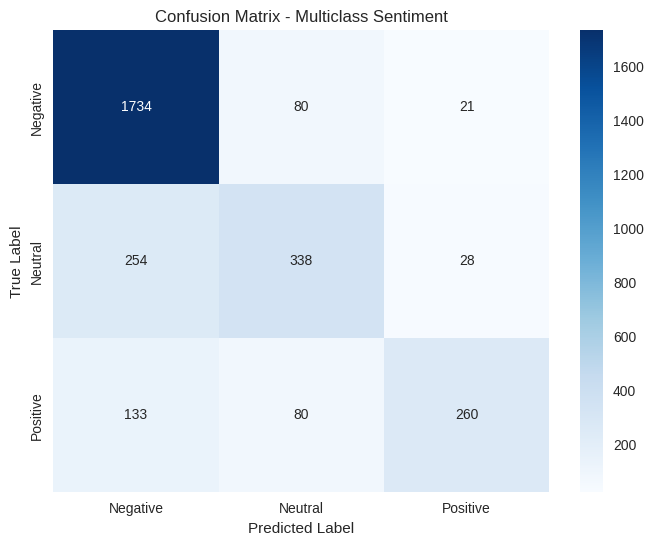


Detailed Error Analysis:

Top 5 Most Interesting Misclassifications:

Example 1
Text:  i have been on hold for over  minutes  please help 
True Sentiment: Neutral
Predicted Sentiment: Negative
Model Confidence: 0.9800
Probability Distribution:
Negative: 0.5856
Neutral: 0.2847
Positive: 0.1297
--------------------------------------------------------------------------------

Example 2
Text:  i was under the impression when there is an  hour delay in your flight because of equipment failure compensation is offered
True Sentiment: Neutral
Predicted Sentiment: Negative
Model Confidence: 0.9782
Probability Distribution:
Negative: 0.3792
Neutral: 0.1911
Positive: 0.4297
--------------------------------------------------------------------------------

Example 3
Text:  thank you
True Sentiment: Neutral
Predicted Sentiment: Positive
Model Confidence: 0.9662
Probability Distribution:
Negative: 0.9498
Neutral: 0.0282
Positive: 0.0220
---------------------------------------------------------------

In [18]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Define the clean_text function
def clean_text(text):
    # Cleaning steps: remove URLs, mentions, special characters, etc.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special characters
    return text.lower()  # return cleaned text in lowercase

# Load the Twitter Airlines dataset
print("Loading Twitter Airlines dataset...")
tweets_df = pd.read_csv("hf://datasets/osanseviero/twitter-airline-sentiment/Tweets.csv")

# Check for missing values
print("Checking for missing values...")
print(tweets_df.isnull().sum())

# Clean the tweets using the existing clean_text function
print("Cleaning tweets...")
tweets_df['clean_text'] = tweets_df['text'].apply(clean_text)

# Filter relevant columns and drop missing values
tweets_df = tweets_df[['clean_text', 'airline_sentiment']].dropna()

# Convert sentiment labels to numerical values
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
tweets_df['sentiment_label'] = tweets_df['airline_sentiment'].map(sentiment_map)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    tweets_df['clean_text'],
    tweets_df['sentiment_label'],
    test_size=0.2,
    random_state=42,
    stratify=tweets_df['sentiment_label']
)

# Ensure X_train and X_test are Series
print(type(X_train), type(X_test))
print(X_train.head())

# Use TF-IDF vectorizer
print("Generating TF-IDF features...")
tweets_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tweets_tfidf.fit_transform(X_train)
X_test_tfidf = tweets_tfidf.transform(X_test)

# Train Logistic Regression model for multiclass
print("Training Logistic Regression model...")
multiclass_model = LogisticRegression(multi_class='multinomial', max_iter=1000)
multiclass_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = multiclass_model.predict(X_test_tfidf)
y_pred_proba = multiclass_model.predict_proba(X_test_tfidf)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
micro_f1 = f1_score(y_test, y_pred, average='micro')

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Micro F1: {micro_f1:.4f}")

# Print classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred,
                          target_names=['Negative', 'Neutral', 'Positive']))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Multiclass Sentiment')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Error Analysis
print("\nDetailed Error Analysis:")

# Create DataFrame with actual and predicted labels
error_df = pd.DataFrame({
    'original_text': X_test.reset_index(drop=True),
    'true_sentiment': y_test.reset_index(drop=True),
    'predicted_sentiment': y_pred,
    'confidence': np.max(y_pred_proba, axis=1)
})

# Find misclassified examples
misclassified = error_df[error_df['true_sentiment'] != error_df['predicted_sentiment']].copy()

# Sort by confidence to find the most interesting mistakes
misclassified['sentiment_diff'] = abs(
    misclassified['true_sentiment'] - misclassified['predicted_sentiment']
)

print("\nTop 5 Most Interesting Misclassifications:")
top_5_mistakes = misclassified.nlargest(5, 'confidence').reset_index(drop=True)

for i, row in top_5_mistakes.iterrows():
    print("\nExample", i + 1)
    print("Text:", row['original_text'])
    print("True Sentiment:", ['Negative', 'Neutral', 'Positive'][row['true_sentiment']])
    print("Predicted Sentiment:", ['Negative', 'Neutral', 'Positive'][row['predicted_sentiment']])
    print("Model Confidence:", f"{row['confidence']:.4f}")

    # Additional analysis for each mistake
    prob_distribution = y_pred_proba[i]
    print("Probability Distribution:")
    for sentiment, prob in zip(['Negative', 'Neutral', 'Positive'], prob_distribution):
        print(f"{sentiment}: {prob:.4f}")
    print("-" * 80)

# Feature Importance Analysis
print("\nMost Influential Words for Each Sentiment:")
feature_names = tweets_tfidf.get_feature_names_out()

for class_idx, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
    coef = multiclass_model.coef_[class_idx]
    top_coef_idx = np.argsort(coef)[-10:]
    top_features = [(feature_names[i], coef[i]) for i in top_coef_idx]

    print(f"\nTop 10 words indicating {sentiment} sentiment:")
    for word, coefficient in reversed(top_features):
        print(f"{word}: {coefficient:.4f}")
